# Basic neural encoder

author: laquitainesteeve@gmail.com

Execution time: 1 sec

Tested on:  
- Apple M4 16GB RAM (no GPU required)
- Ubuntu 180 GB RAM



**Method**:
- tuning parameters: standard deviations are based on literature data and we assume continuous neuron orientation and direction preferences.
- tunings curves are from the middle temporal area (MT) and robust across species (see study notebook)

## Setup 

activate fisher_info_limits2

```python
python -m ipykernel install --user --name fisher_info_limits2 --display-name "fisher_info_limits2"
```

In [9]:
%load_ext autoreload
%autoreload 2

# import packages
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import pickle5 as pickle
from scipy.stats import spearmanr, wilcoxon
from matplotlib.gridspec import GridSpec as GS
import math
from scipy.stats import poisson
from scipy.optimize import minimize_scalar
from scipy.special import radian as rad
from scipy.stats import circstd
from tqdm import tqdm
from scipy.special import gammaln
from scipy.optimize import curve_fit

# setup project path
main_dir = '/home/steeve/steeve/idv/code/fisher-info-limits'
os.chdir(main_dir)

# import custom package
import ssiProjectModule as ssiMod

# setup parameters
sample_size = 500
theta_step = 2
stim = np.arange(0, 360, theta_step) # stimulus direction space

# setup ssi parameters
constant = 360/np.sqrt(2*np.pi*math.e)

# setup Bayesian parameters
N_TRIALS = 500

# setup paths
dat_dir_in = os.path.join(main_dir, 'data/decoding_analysis/')
data_dir = 'data/bayer_decoding_error/'+f'Bayes_Dec_Errs_{sample_size}reps_thetastep{theta_step}'+'.npz'
title = f'Stretch_BioQuads_multiplied_w_mean_g__theta_step={theta_step}_original_g_20240509_AREA.pkl'

# setup figure parameters
labelsize = 9
legend_fontsize = 8
text_size = 9
tick_labelsize = 9
lw = 1
plt.rcParams['xtick.labelsize'] = tick_labelsize
plt.rcParams['ytick.labelsize'] = tick_labelsize
mpl.rcParams['axes.spines.right'] = False

# setup tuning curves colors
cmap = plt.cm.viridis
values = np.linspace(0, 1, 40)
colors = [cmap(v) for v in values[::2]]

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Functions

In [2]:
# neural encoder model --------------------------------------------

def create_tuning_curves(n_neurons=20, amplitude=780, width=0.29, baseline=0, stim=stim):
    """
    Create direction tuning curves for a population of neurons.

    Parameters:
    - n_neurons (int): Number of neurons
    - amplitude (float): Amplitude of the tuning curve
    - width (float): Width (kappa or std) of the tuning curve
    - baseline (float): Baseline firing rate
    - stim (np.ndarray): Stimulus directions

    Returns:
    - tuning_c (np.ndarray): Array of shape (n_neurons, len(stim))
    - preferred_directions (np.ndarray): Preferred directions of neurons
    """
    # setup the preferred angle of each neuron
    preferred_directions = np.linspace(0, 360, n_neurons, endpoint=False) 

    # create tuning curves
    tuning_c = []
    for _, pref_angle in enumerate(preferred_directions):
        tuning_c.append(ssiMod.VON_MISES(th=stim, a=amplitude, th_0=pref_angle, s=width, baseline=baseline))
    tuning_c = np.array(tuning_c)
    return tuning_c, preferred_directions


# Bayesian decoder --------------------------------------------


def generate_responses(tuning_curves, true_direction_index, n_trials=10, seed=0):
    """
    Generate Poisson spike counts for all neurons given a true direction.
    
    Parameters:
    - true_direction_index: true motion direction index 
    - n_trials: number of trials to simulate
    
    Returns:
    - responses: array of spike counts [n_trials, n_neurons]
    """
    # setup reproducibility
    np.random.seed(seed)

    # parameters
    n_neurons = tuning_curves.shape[1]
    responses = np.zeros((n_trials, n_neurons))
    
    for n_i in range(n_neurons):
        mean_firing_rate = tuning_curves[true_direction_index, n_i]
        responses[:, n_i] = poisson.rvs(mean_firing_rate, size=n_trials)
    return responses


def log_likelihood(direction_index, responses, tuning_curves):
    """Compute log likelihood of observed responses given a direction.
    
    Parameters:
    - direction (float): candidate direction (degrees)
    - responses: observed spike counts for all neurons
    
    Returns:
    - log_likelihood: log probability of the data
    """
    n_neurons = tuning_curves.shape[1]
    direction_index = int(direction_index) # make an integer 

    log_prob = 0
    
    # Poisson log likelihood ( sum(r * ln(mean_r) - mean_r) )
    for n_i in range(n_neurons):
        mean_firing_rate = tuning_curves[direction_index, n_i]
        log_prob += responses[n_i] * np.log(mean_firing_rate + 1e-10) - mean_firing_rate - gammaln(responses[n_i] + 1)
    return log_prob


def compute_likelihood(responses, tuning_c):
    """Calculate likelihoods for all candidate directions given responses.
    
    Args:
        responses (np.array): vector of n neurons responses
        tuning_c (np.array): tuning curve matrix of shape (n_directions, n_neurons)
    """
    n_stim = tuning_c.shape[0]
    llh = []
    for candidate_dir_ix in range(n_stim):
        llh.append(log_likelihood(candidate_dir_ix, responses, tuning_c))
    return np.exp(np.array(llh))


def get_circular_mean(prob, directions):
    """Simplest form assuming 360 evenly spaced directions from 0° to 359°
    """
    # get directions
    dir = np.deg2rad(directions)
    
    # normalize probabilities
    prob = prob / np.sum(prob)
    
    # calculate components
    x = np.sum(prob * np.cos(dir))
    y = np.sum(prob * np.sin(dir))
    
    # return mean in degrees
    return np.degrees(np.arctan2(y, x)) % 360


def decode_direction(responses, tuning_c, stim):
    llh = compute_likelihood(responses, tuning_c)
    return get_circular_mean(llh, stim)


def compute_bayesian_decoding_error(true_directions, tuning_c, n_trials=100, seed=0):

    all_true_dirs = []
    all_decoded_dirs = []
    all_errors_deg = []
    all_errors_rad = []

    # loop over stimulus in stimulus space
    for dir_ix, true_dir in tqdm(enumerate(true_directions), total=len(true_directions)):

        # (n trials, 4 neurons) responses
        responses = generate_responses(tuning_c.T, int(dir_ix), n_trials=n_trials, seed=seed)

        # loop over many trials
        for trial in range(n_trials):
            
            #llh = compute_likelihood(responses[trial,:], tuning_c.T)
            #decoded_dir = get_circular_mean(llh, stim)
            decoded_dir = decode_direction(responses[trial,:], tuning_c.T, stim)
            
            # # decode each trial
            # decoded_dir_ix = decode_direction(responses[trial,:], 
            #                                   tuning_c.T, 
            #                                   bounds=(0, len(true_directions)-1))
            # decoded_dir = true_directions[decoded_dir_ix]

            # compute circular error
            error_deg = min(abs(decoded_dir - true_dir), 360 - abs(decoded_dir - true_dir))       
            error_rad = rad(error_deg, 0, 0)

            # record direction x trials
            all_true_dirs.append(true_dir)
            all_decoded_dirs.append(decoded_dir)
            all_errors_deg.append(error_deg)         
            all_errors_rad.append(error_rad)      

    all_true_dirs = np.array(all_true_dirs)
    all_decoded_dirs = np.array(all_decoded_dirs)
    all_errors_deg = np.array(all_errors_deg)
    all_errors_rad = np.array(all_errors_rad)

    # calculate estimate errors as std
    stds_deg = []
    stds_circ = []
    
    for _, true_dir in enumerate(true_directions):

        this_true_dir_pos = all_true_dirs== true_dir
        
        # method 1: std over degrees
        std_deg = np.sqrt((all_errors_deg[this_true_dir_pos]**2).mean())
        
        # method 2: circular std over radians
        std_circ = circstd(all_errors_rad[this_true_dir_pos])
        
        # record
        stds_deg.append(std_deg)
        stds_circ.append(std_circ)

    stds_deg = np.array(stds_deg)
    stds_circ = np.array(stds_circ)

    return {
        'true_directions': all_true_dirs,
        'decoded_directions': all_decoded_dirs,
        'errors_deg': all_errors_deg,
        'errors_rad': all_errors_rad,
        'stds_deg': stds_deg,
        'stds_circ': stds_circ
    }

## Neural encoder model

In [3]:
%%time

# create 1D directional tuning curves
# - n_neurons=20 - a tiling with 20 neurons (Kriegeskorte, Nature, Rev, Neuro)
# - amplitude=780 - 19 spikes/secs (Albright, 1984)  (from Gaussian fit)
# - width =0.29 - for 32 deg std (~75 deg FWHM), validated across species (from Gaussian fit)
tuning_c, preferred_directions = create_tuning_curves(n_neurons=20, amplitude=780, width=0.29, baseline=0, stim=stim)

CPU times: user 366 µs, sys: 12 µs, total: 378 µs
Wall time: 371 µs


## Compute metrics

- execution time: 

In [4]:
%%time 

# FISHER INFO & ERROR 
# with a flat prior and unbiased estimator
fisher_info = ssiMod.FISHER_POISSON(stim, tuning_c)
fisher_error = 1/np.sqrt(fisher_info)

CPU times: user 941 µs, sys: 0 ns, total: 941 µs
Wall time: 844 µs


In [5]:
%%time

# BAYES ERROR
bayes_data = compute_bayesian_decoding_error(stim, tuning_c, n_trials=N_TRIALS, seed=0)
bayes_error = bayes_data['stds_deg']

  0%|          | 0/180 [00:00<?, ?it/s]

100%|██████████| 180/180 [04:02<00:00,  1.35s/it]

CPU times: user 4min 2s, sys: 31.5 ms, total: 4min 2s
Wall time: 4min 2s


In [6]:
%%time

# SSI
tuning_c, preferred_directions = create_tuning_curves(n_neurons=10, amplitude=780, width=0.29, baseline=0, stim=stim)
ssi = ssiMod.ssi_adaptive_monte_carlo(tuning_c, num_samples=1000, max_num_samples=10**6, error=1)

CPU times: user 21.6 s, sys: 8.85 s, total: 30.5 s
Wall time: 30.5 s


## Plot

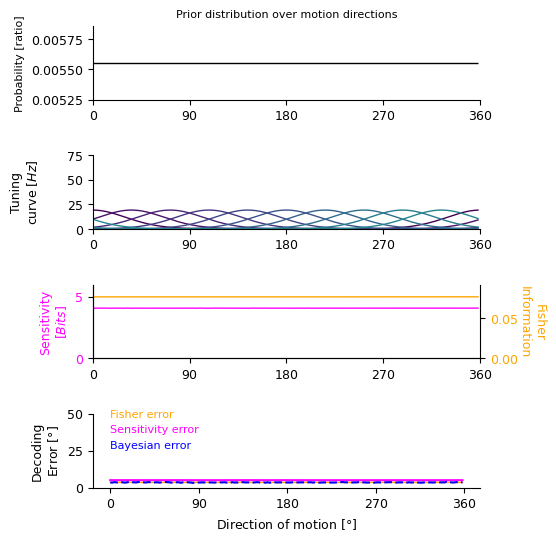

In [32]:
# setup plot
fig = plt.figure(figsize=(5,6))
gs = GS(4,1, wspace=0.3, hspace=0.75) # setup subplots

# plot prior distribution -----------------------------------s

ax = fig.add_subplot(gs[0,0])

ax.hlines(xmin=stim[0], xmax=stim[-1], y=1/len(stim), color = "k", linewidth=lw)
ax.set_title('Prior distribution over motion directions', fontsize=legend_fontsize)
ax.set_ylabel('Probability [ratio]', fontsize=legend_fontsize)
ax.set_xticks(np.arange(0,361, 90))
ax.set_xlim([0, 360])

# plot neural encoder model (1D dense tuning-curves) ----------------

ax = fig.add_subplot(gs[1,0])

for j, tc in enumerate(tuning_c):
    line = ax.plot(stim, tc, color = colors[j], linewidth=lw)

# legend
ax.set_xlim(0,360)
ax.set_ylim(0,75)    
ax.set_xticks(np.arange(0,361, 90))
ax.set_yticks(np.arange(0,76, 25))
# ax.legend(handles=line, frameon=False, fontsize = legend_fontsize, loc=(0.01, 0.75))
ax.yaxis.set_label_coords(-0.135, y=0.5)
ax.set_ylabel('Tuning\n'+r'curve [$Hz$]', size = labelsize)  

# plot sensitivity metrics ---------------------------------------

# setup
ax1 = fig.add_subplot(gs[2,0])
ax2 = ax1.twinx()

# plot
ax1.plot(stim, ssi, color = 'magenta', linewidth=lw)
ax2.plot(stim, fisher_info, color = 'orange', linewidth=lw)

# aesthetics
ax1.set_ylabel('Sensitivity\n'+r'[$Bits$]', color = 'magenta', size = labelsize)
ax1.tick_params('y', labelcolor = 'magenta')
ax1.set_xticks(np.arange(0,361, 90))
ax1.set_xlim(0,360)
ax1.set_ylim(0,6)

ax2.set_ylabel('Fisher\n'+r'Information', rotation=270, color = 'orange', size = labelsize)        
ax2.spines['right'].set_visible(True)
ax2.tick_params('y', labelcolor = 'orange')
ax2.yaxis.set_label_coords(x=1.17, y=0.5) # position ylabel
ax2.set_ylim(0, max(fisher_info)*1.2)

# plot decoding errors ----------------------------------------------------

ax3 = fig.add_subplot(gs[3,0])
ax3.plot(stim, fisher_error, color = 'orange', linewidth=lw, label='Fisher error')                 # Fisher error
ax3.plot(stim, constant*math.e**(-ssi*np.log(2)), color = 'magenta', label = r'Sensitivity error') # SSI error
ax3.plot(stim, bayes_error, color = 'blue', linestyle='--', label='Bayesian error')                # Bayes error

# aesthetics
ax3.set_xlabel('Direction of motion [$\degree$]', size = labelsize)
ax3.set_ylabel('Decoding\n'+r'Error [$\degree$]', size = labelsize)  
ax3.set_xticks(np.arange(0,361, 90))
ax3.set_ylim(0,50) 
ax3.legend(handlelength = 0, labelcolor = 'linecolor', frameon=0, \
            loc = (0.01, 0.45), fontsize = legend_fontsize)

fig.subplots_adjust(hspace=-1)

# save figure
plt.savefig('figures/fig1.svg', bbox_inches='tight', dpi = 400)